## Model Training and Development
Linear Learner

In [4]:
##Setup
import sagemaker
sess = sagemaker.Session()
bucket=sess.default_bucket()
prefix = 'sagemakerbankfraud-xgboost'

# Define IAM role

import re
from sagemaker import get_execution_role

role = get_execution_role()

In [51]:
#Import all potential libraries
import boto3
import numpy as np                                # For matrix operations and numerical processing
import pandas as pd                               # For munging tabular data
from IPython.display import Image                 # For displaying images in the notebook
from IPython.display import display               # For displaying outputs in the notebook
from time import gmtime, strftime                 # For labeling SageMaker models, endpoints, etc.
import sklearn
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import CSVSerializer
import csv
import seaborn as sns
sns.set_style('white')                            #Set theme for Seaborn
import matplotlib.pyplot as plt                   # For charts and visualizations
import sys                                        # For writing outputs to notebook
import os # For manipulating filepath names
%matplotlib inline
import io
import json
import sagemaker
import sagemaker.amazon.common as smac
from sagemaker import get_execution_role
from sagemaker.predictor import csv_serializer, json_deserializer

In [4]:
###read in preprocessed data from S3
import boto3
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'preprocessed/preprocessed.csv')).download_file('preprocessed.csv')

In [11]:
###read in csv file into dataframe
data = pd.read_csv('preprocessed.csv')


In [12]:
display(data.describe())
display(data.isfraud.value_counts())

,Unnamed: 0,isfraud,step,amount,oldbalanceorg,newbalanceorig,oldbalancedest,newbalancedest,morning,afternoon,evening,OrigCust,DestCust,TRANSFER,CASH_OUT,OrigAmountDiff,DestAmountDiff
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6362620.0,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,3.184236e+06,1.290820e-03,3.266809e-01,1.945599e-03,1.399484e-02,1.724540e-02,3.091721e-03,3.439269e-03,3.482094e-01,3.234744e-01,3.283162e-01,0.0,6.618539e-01,8.375622e-02,3.516633e-01,9.986284e-01,1.165040e-01
std,1.836756e+06,3.590480e-02,1.918221e-01,6.532045e-03,4.847261e-02,5.897038e-02,9.547833e-03,1.031539e-02,4.764028e-01,4.678021e-01,4.696006e-01,0.0,4.730786e-01,2.770219e-01,4.774895e-01,6.428786e-03,4.757423e-03
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.593596e+06,0.000000e+00,2.088949e-01,1.448374e-04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,9.987614e-01,1.163413e-01
50%,3.184250e+06,0.000000e+00,3.207547e-01,8.099034e-04,2.384491e-04,0.000000e+00,3.727521e-04,6.026781e-04,0.000000e+00,0.000000e+00,0.000000e+00,0.0,1.000000e+00,0.000000e+00,0.000000e+00,9.999373e-01,1.164338e-01
75%,4.774905e+06,0.000000e+00,4.501348e-01,2.257778e-03,1.801042e-03,2.909313e-03,2.648861e-03,3.121768e-03,1.000000e+00,1.000000e+00,1.000000e+00,0.0,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.164338e-01
max,6.365560e+06,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


0    6354407
1       8213
Name: isfraud, dtype: int64

In [10]:
# Set data locations

prefix = 'sagemaker/linear-learner-bank-fraud-loss-weights'   
s3_train_key = '{}/train/recordio-pb-data'.format(prefix)
s3_train_path = os.path.join('s3://', bucket, s3_train_key)

s3_validation_key = '{}/validation/recordio-pb-data'.format(prefix)
s3_validation_path = os.path.join('s3://', bucket, s3_validation_key)

In [13]:
#Read the data, shuffle, and split into train and test sets, separating the labels (last column) from the features
rand_split = np.random.rand(len(data))
train_list = rand_split < 0.8
val_list = (rand_split >= 0.8) & (rand_split < 0.9)
test_list = rand_split >= 0.9

data_train = data[train_list]
data_val = data[val_list]
data_test = data[test_list]

train_y = ((data_train.iloc[:,1] == 1) +0).to_numpy();
train_X = data_train.iloc[:,2:].to_numpy();

val_y = ((data_val.iloc[:,1] == 1) +0).to_numpy();
val_X = data_val.iloc[:,2:].to_numpy();

test_y = ((data_test.iloc[:,1] == 1) +0).to_numpy();
test_X = data_test.iloc[:,2:].to_numpy();

In [14]:
val_y

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

## CSV METHOD

In [15]:
###create csv files as AWS Xgboost requires libSVM or CSV - 
#pd.concat([train_y, train_x], axis=1).to_csv('train.csv', index=False, header=False)
#pd.concat([val_y, val_y], axis=1).to_csv('validation.csv', index=False, header=False)

In [16]:
#boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
#boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

In [17]:
###set up training input and  shard by S3Key
##s3_input_validation = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/validation'.format(bucket, prefix), content_type='csv')

## RecordIO Method

In [22]:

train_file = 'linear_train.data'

f = io.BytesIO()
smac.write_numpy_to_dense_tensor(f, train_X.astype('float32'), train_y.astype('float32'))
f.seek(0)

boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', train_file)).upload_fileobj(f)

In [23]:
validation_file = 'linear_validation.data'

f = io.BytesIO()
smac.write_numpy_to_dense_tensor(f, val_X.astype('float32'), val_y.astype('float32'))
f.seek(0)

boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation', validation_file)).upload_fileobj(f)

## Training Linear Learner

In [24]:
###bring in container artifact
container = sagemaker.image_uris.retrieve("linear-learner", boto3.Session().region_name)
display(container)

'382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:1'

In [28]:
import time
linear_job = 'linear-learner-fraud-' + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
linear_job = 'linear-learner-fraud-2021-01-08-00-51-41'



print("Job name is:", linear_job)

linear_training_params = {
    "RoleArn": role,
    "TrainingJobName": linear_job,
    "AlgorithmSpecification": {
        "TrainingImage": container,
        "TrainingInputMode": "File"
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.m5.4xlarge",
        "VolumeSizeInGB": 10
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": "s3://{}/{}/train/".format(bucket, prefix),
                    "S3DataDistributionType": "ShardedByS3Key"
                }
            },
            "CompressionType": "None",
            "RecordWrapperType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": "s3://{}/{}/validation/".format(bucket, prefix),
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "CompressionType": "None",
            "RecordWrapperType": "None"
        }

    ],
    "OutputDataConfig": {
        "S3OutputPath": "s3://{}/{}/".format(bucket, prefix)
    },
    "HyperParameters": {
        "feature_dim": "15",
        "mini_batch_size": "100",
        "predictor_type": "binary_classifier",
        "epochs": "2",
        "binary_classifier_model_selection_criteria": "precision_at_target_recall",
        "target_recall": "0.9",
        "positive_example_weight_mult": "balanced"
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 60 * 120
    }
}

Job name is: linear-learner-fraud-2021-01-08-00-51-41


## Build Training Job Method

In [19]:
%%time

region = boto3.Session().region_name
sm = boto3.client('sagemaker')

sm.create_training_job(**linear_training_params)

status = sm.describe_training_job(TrainingJobName=linear_job)['TrainingJobStatus']
print(status)
sm.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=linear_job)
if status == 'Failed':
    message = sm.describe_training_job(TrainingJobName=linear_job)['FailureReason']
    print('Training failed with the following error: {}'.format(message))
    raise Exception('Training job failed')

Completed
CPU times: user 65.8 ms, sys: 3.61 ms, total: 69.4 ms
Wall time: 120 ms


## HOST and Evaluate

In [31]:
###Host Model
linear_hosting_container = {
    'Image': container,
    'ModelDataUrl': sm.describe_training_job(TrainingJobName=linear_job)['ModelArtifacts']['S3ModelArtifacts']
}

create_model_response = sm.create_model(
    ModelName=linear_job,
    ExecutionRoleArn=role,
    PrimaryContainer=linear_hosting_container)

print(create_model_response['ModelArn'])

arn:aws:sagemaker:us-east-1:246778806733:model/linear-learner-fraud-2021-01-08-00-51-41


In [32]:
###set up endpoint autoscaling feature
from time import strftime, gmtime
timestamp = strftime("%Y-%m-%d-%H-%M-%S", gmtime())

model_name = linear_job
linear_endpoint_config = 'linear-learner-fraud-epc' +timestamp
linear_endpoint = 'linear-learner-fraud-' + time.strftime("%Y%m%d%H%M", time.gmtime())

production_variants = [{
    'VariantName':'variant-1',
    'ModelName':model_name,
    'InstanceType':'ml.m5.xlarge',
    'InitialVariantWeight':1,
    'InitialInstanceCount':2,
    
}]

In [37]:
create_endpoint_config_response = sm.create_endpoint_config(
    EndpointConfigName = linear_endpoint_config,
    ProductionVariants = production_variants)

print("Endpoint Config Arn: " + create_endpoint_config_response['EndpointConfigArn'])

Endpoint Config Arn: arn:aws:sagemaker:us-east-1:246778806733:endpoint-config/linear-learner-fraud-epc2021-01-08-14-16-38


In [38]:

%%time
print(linear_endpoint)
create_endpoint_response = sm.create_endpoint(
    EndpointName=linear_endpoint,
    EndpointConfigName=linear_endpoint_config)
print(create_endpoint_response['EndpointArn'])

resp = sm.describe_endpoint(EndpointName=linear_endpoint)
status = resp['EndpointStatus']
print("Status: " + status)

sm.get_waiter('endpoint_in_service').wait(EndpointName=linear_endpoint)

resp = sm.describe_endpoint(EndpointName=linear_endpoint)
status = resp['EndpointStatus']
print("Arn: " + resp['EndpointArn'])
print("Status: " + status)

if status != 'InService':
    raise Exception('Endpoint creation did not succeed')

linear-learner-fraud-202101081416
arn:aws:sagemaker:us-east-1:246778806733:endpoint/linear-learner-fraud-202101081416
Status: Creating
Arn: arn:aws:sagemaker:us-east-1:246778806733:endpoint/linear-learner-fraud-202101081416
Status: InService
CPU times: user 155 ms, sys: 8.54 ms, total: 163 ms
Wall time: 6min 31s


In [39]:
#print(endpoint_name)
ResourceId='endpoint/'+linear_endpoint+'/variant/variant-1'
print(ResourceId)

endpoint/linear-learner-fraud-202101081416/variant/variant-1


In [40]:
app2 = boto3.client('application-autoscaling')

In [41]:
###register a policy once endpoint is created
app2.register_scalable_target(
    ServiceNamespace ='sagemaker',
    ResourceId = ResourceId,
    ScalableDimension= 'sagemaker:variant:DesiredInstanceCount',
    MinCapacity=2,
    MaxCapacity=10)

{'ResponseMetadata': {'RequestId': 'd00ead0e-6e62-4127-a2f2-b6653d3d8600',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'd00ead0e-6e62-4127-a2f2-b6653d3d8600',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '2',
   'date': 'Fri, 08 Jan 2021 14:25:10 GMT'},
  'RetryAttempts': 0}}

In [42]:
policy_name ='linear-learner-scaling-policy' #name policy

In [43]:
###apply poliy to target 
app2.put_scaling_policy(
    PolicyName=policy_name,
    ServiceNamespace = 'sagemaker',
    ResourceId = ResourceId,
    ScalableDimension= 'sagemaker:variant:DesiredInstanceCount',
    PolicyType = 'TargetTrackingScaling',
    TargetTrackingScalingPolicyConfiguration={
        'TargetValue': 1000.0,
        'PredefinedMetricSpecification':{
            'PredefinedMetricType':'SageMakerVariantInvocationsPerInstance'},
        'ScaleInCooldown': 60,
        'ScaleOutCooldown': 60
    }
    
)

{'PolicyARN': 'arn:aws:autoscaling:us-east-1:246778806733:scalingPolicy:1e8d3858-6fc7-4a52-af5a-3bf30100406c:resource/sagemaker/endpoint/linear-learner-fraud-202101081416/variant/variant-1:policyName/linear-learner-scaling-policy',
 'Alarms': [{'AlarmName': 'TargetTracking-endpoint/linear-learner-fraud-202101081416/variant/variant-1-AlarmHigh-d1199047-b25a-436f-b198-0cdebe6156df',
   'AlarmARN': 'arn:aws:cloudwatch:us-east-1:246778806733:alarm:TargetTracking-endpoint/linear-learner-fraud-202101081416/variant/variant-1-AlarmHigh-d1199047-b25a-436f-b198-0cdebe6156df'},
  {'AlarmName': 'TargetTracking-endpoint/linear-learner-fraud-202101081416/variant/variant-1-AlarmLow-41261d4b-42c3-44a5-9a8d-9c7f0bbcb4bc',
   'AlarmARN': 'arn:aws:cloudwatch:us-east-1:246778806733:alarm:TargetTracking-endpoint/linear-learner-fraud-202101081416/variant/variant-1-AlarmLow-41261d4b-42c3-44a5-9a8d-9c7f0bbcb4bc'}],
 'ResponseMetadata': {'RequestId': 'bbf30014-d274-40cf-98fb-7ed5336a3981',
  'HTTPStatusCode': 

## Create Test Data

In [104]:
###get test data in correct format to invoke endpoint to evaluate
##tested 1000 items

test_X = data_test.iloc[:,2:];
test_y = ((data_test.iloc[:,1] == 1) +0);

test_data_tail = test_X.tail(100)

test_data_tail.to_csv('test_data_tail.csv',header =False, index=False)


In [94]:
runtime_client = boto3.Session().client('runtime.sagemaker')

In [95]:
##invoke endpoint
import time
print(f"Sending test traffic to the endpoint {linear_endpoint}. \nPlease wait...")

predictions = []

with open('test_data_tail.csv', 'r') as f:
    for row in f:
        print(".", sep=',', end='', flush=True)
        payload = row.rstrip('\n')
        response = runtime_client.invoke_endpoint(EndpointName=linear_endpoint,
                                       ContentType="text/csv",
                                       Accept='Accept',
                                       Body=payload)
        result = json.loads(response['Body'].read().decode())
        preds =  [r['predicted_label'] for r in result['predictions']]
        predictions.append(preds)
        time.sleep(0.5)

         
        
print("Done!")

print(predictions)

Sending test traffic to the endpoint linear-learner-fraud-202101081416. 
Please wait...
....................................................................................................Done!
[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [1], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [1], [0], [0], [0], [0], [0], [1], [0], [0], [0], [1], [1], [1], [1], [1], [1], [1], [1], [1], [0], [0], [1], [1], [1], [1], [1], [1], [1], [1], [0], [1], [1], [1]]


In [132]:
#Convert our predictions to a numpy array
predsnp = pd.Series( (v[0] for v in predictions) )
        
len(predsnp)
type(predsnp)

pandas.core.series.Series

## Evaluation of test Results

In [117]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from sklearn.metrics import roc_auc_score

test_actuals = test_y.tail(100)
test_actuals = test_actuals.to_numpy()

len(test_actuals)
type(test_actuals)

numpy.ndarray

In [134]:
import pandas as pd 
y_actu = pd.Series(test_actuals)
y_pred = predsnp


In [137]:
###set up confusion matrix
from sklearn.metrics import confusion_matrix
df_confusion = pd.crosstab(index=y_actu, columns=y_pred, rownames=['actuals'], colnames=['predictions'])
df_conf_norm = df_confusion / df_confusion.sum(axis=1)
df_conf_norm

predictions,0,1
actuals,,
0,0.985915,0.034483
1,0.084507,0.793103


Accuracy: 0.93
Precision: 0.9583333333333334
Recall: 0.7931034482758621
F1 Score: 0.8679245283018867
AUC is 0.8895


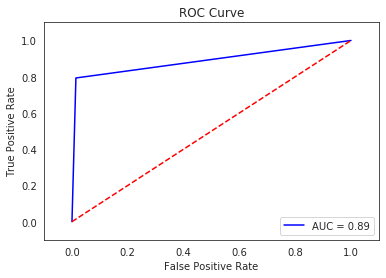

In [138]:
# Calculate accuracy
accuracy = sum(y_pred == y_actu) / len(y_pred)
print(f'Accuracy: {accuracy}')

# Calculate precision
precision = sum(y_pred[y_pred == 1] == y_actu[y_pred == 1]) / len(y_pred[y_pred == 1])
print(f'Precision: {precision}')

# Calculate recall
recall = sum(y_pred[y_pred == 1] == y_actu[y_pred == 1]) / len(y_actu[y_actu == 1])
print(f'Recall: {recall}')

# Calculate F1 score
f1_score = 2 * (precision * recall) / (precision + recall)
print(f'F1 Score: {f1_score}')

# Calculate AUC
auc = round(roc_auc_score(y_actu, y_pred), 4)
print('AUC is ' + repr(auc))

fpr, tpr, _ = metrics.roc_curve(y_actu, y_pred)

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

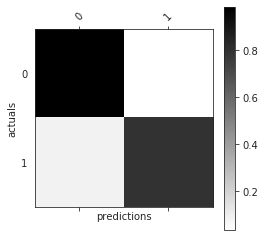

In [139]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

plot_confusion_matrix(df_conf_norm)

## DETELE ALL ENDPOINTS

In [106]:
####to save cost and delete since this is a demo-project
app2.delete_scaling_policy(
    PolicyName=policy_name,
    ServiceNamespace = 'sagemaker',
    ResourceId = 'endpoint/xgboost-bankfraud/variant/variant-1',
    ScalableDimension= 'sagemaker:variant:DesiredInstanceCount',
)
sm.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': 'bba6d8f9-724f-4acd-857a-74b01e6e08a1',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'bba6d8f9-724f-4acd-857a-74b01e6e08a1',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Tue, 05 Jan 2021 19:24:10 GMT'},
  'RetryAttempts': 0}}

In [107]:
sm.delete_endpoint_config(
    EndpointConfigName=endpoint_config_name)

{'ResponseMetadata': {'RequestId': '2f72459a-9b2c-4d1a-82c9-078c181ee6d9',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '2f72459a-9b2c-4d1a-82c9-078c181ee6d9',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Tue, 05 Jan 2021 19:24:12 GMT'},
  'RetryAttempts': 0}}